# Seasonal dummy features: Linear models
14 April 2024

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import re

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

# Output a pandas df intead of numpy
set_config(transform_output="pandas")

## 1) Input data

In [3]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

# # Filter to the previous 3 years
# data = data.loc["2012":]
data

,demand
date_time,
2012-01-01 00:00:00,"7,926.5294"
2012-01-01 01:00:00,"7,901.8270"
2012-01-01 02:00:00,"7,255.7213"
2012-01-01 03:00:00,"6,792.5034"
2012-01-01 04:00:00,"6,635.9845"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


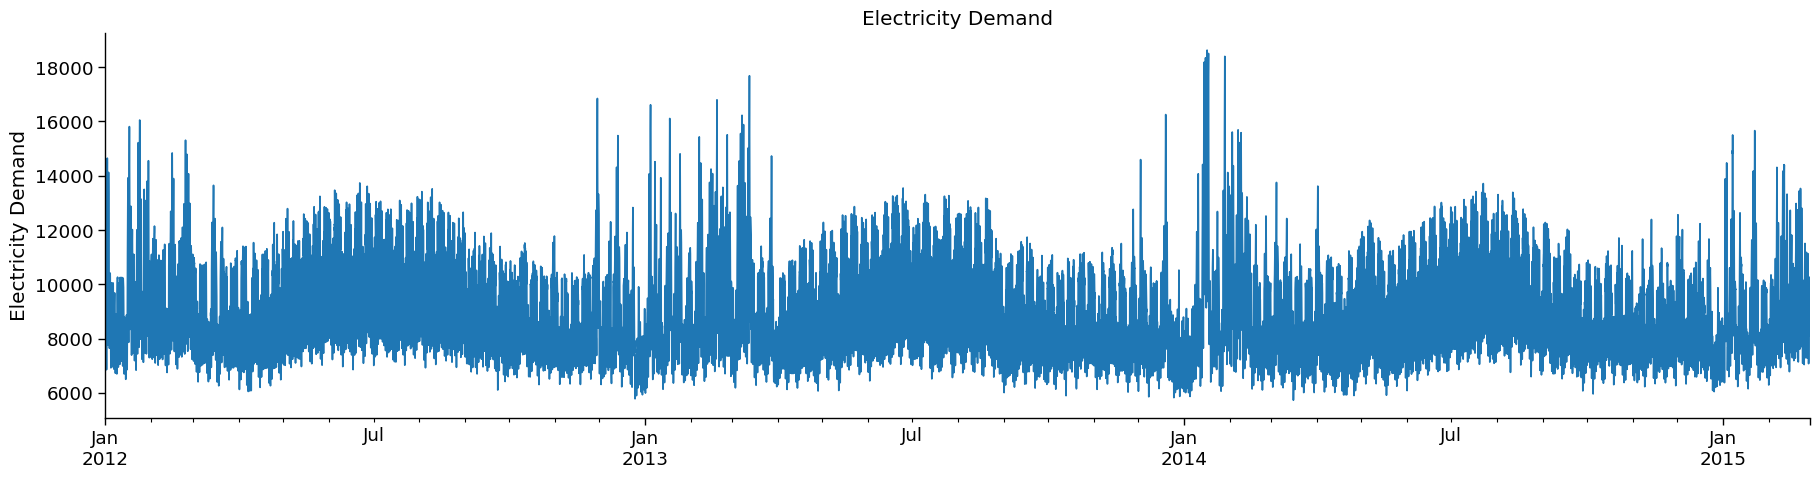

In [4]:
data.plot(legend=None)

plt.title("Electricity Demand")
plt.xlabel("")
plt.ylabel("Electricity Demand")
plt.show()

In [5]:
df = data.copy(deep=True)

## 2) Feature engineering

### 2.1) Pandas: seasonal dummies
Seasonal dummies: are specific for linear models, using datetime features and then one-hot encoding.

In [6]:
df["month_of_year"] = df.index.month
df["week_of_year"] = df.index.isocalendar().week

df.head()

,demand,month_of_year,week_of_year
date_time,,,
2012-01-01 00:00:00,"7,926.5294",1,52
2012-01-01 01:00:00,"7,901.8270",1,52
2012-01-01 02:00:00,"7,255.7213",1,52
2012-01-01 03:00:00,"6,792.5034",1,52
2012-01-01 04:00:00,"6,635.9845",1,52


In [7]:
# One-hot transformer
transformer = OneHotEncoder(
    sparse_output=False, # Pandas output
    drop="first", # n-1 one-hot encoding
)

result = transformer.fit_transform(df[["month_of_year", "week_of_year"]])

print(result.shape)
result.head()

(27720, 62)


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,week_of_year_2.0,week_of_year_3.0,week_of_year_4.0,week_of_year_5.0,week_of_year_6.0,week_of_year_7.0,week_of_year_8.0,week_of_year_9.0,week_of_year_10.0,week_of_year_11.0,week_of_year_12.0,week_of_year_13.0,week_of_year_14.0,week_of_year_15.0,week_of_year_16.0,week_of_year_17.0,week_of_year_18.0,week_of_year_19.0,week_of_year_20.0,week_of_year_21.0,week_of_year_22.0,week_of_year_23.0,week_of_year_24.0,week_of_year_25.0,week_of_year_26.0,week_of_year_27.0,week_of_year_28.0,week_of_year_29.0,week_of_year_30.0,week_of_year_31.0,week_of_year_32.0,week_of_year_33.0,week_of_year_34.0,week_of_year_35.0,week_of_year_36.0,week_of_year_37.0,week_of_year_38.0,week_of_year_39.0,week_of_year_40.0,week_of_year_41.0,week_of_year_42.0,week_of_year_43.0,week_of_year_44.0,week_of_year_45.0,week_of_year_46.0,week_of_year_47.0,week_of_year_48.0,week_of_year_49.0,week_of_year_50.0,week_of_year_51.0,week_of_year_52.0
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


### 2.2) Forecast Pipeline: sktime

In [8]:
seasonal_dummies = [
        "week_of_year",
        "month_of_year",
]

# Create the DateTimeFeatures transformer
datetime_transformer = DateTimeFeatures(
    manual_selection=seasonal_dummies, # Select which features to create
    keep_original_columns=False, # Flag if we want to keep columns in dataframe passed to `transform`.
)

# One-hot encoder
one_hot_encoder = OneHotEncoder(
    sparse_output=False, # Required to enable pandas output.
    drop="first", # n-1
)

# Combine the two transformers in a pipeline
seasonal_dummies_feats = make_pipeline(datetime_transformer, one_hot_encoder)
seasonal_dummies_feats

Pipeline(steps=[('datetimefeatures',
                 DateTimeFeatures(manual_selection=['week_of_year', 'month_of_year'])),
                ('onehotencoder',
                 OneHotEncoder(drop='first', sparse_output=False))])

In [9]:
# Fit and transform to create our features
result = seasonal_dummies_feats.fit_transform(data)

print(result.shape)
result.head()

(27720, 62)


,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2012-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [10]:
target = ["demand"]

df = data.copy()
df.head()

,demand
date_time,
2012-01-01 00:00:00,"7,926.5294"
2012-01-01 01:00:00,"7,901.8270"
2012-01-01 02:00:00,"7,255.7213"
2012-01-01 03:00:00,"6,792.5034"
2012-01-01 04:00:00,"6,635.9845"


In [11]:
# Polynomial time features for trend
time_feats = make_pipeline(
    TimeSince(), 
    PolynomialFeatures(degree=1, include_bias=False)
)

# Create the seasonal dummies transformer.
datetime_features = [
    "month_of_year",
    "day_of_week",
    "hour_of_day",
]
# Datetime features
datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features, 
    keep_original_columns=False, 
)
# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, 
                                drop="first"
)
seasonal_dummies_feats = make_pipeline(datetime_feats, one_hot_encoder)


# Compute lag & window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1]  # Lag features.
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

# Combine pipelines
pipeline = make_union(
    seasonal_dummies_feats,
    time_feats, 
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('datetimefeatures',
                                                                  DateTimeFeatures(manual_selection=['month_of_year', 'day_of_week',
                                   'hour_of_day'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse_output=False))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1]}, target_cols=['demand'],
                 truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [12]:
pipeline.fit_transform(df).head()

,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,time_since_2012-01-01 00:00:00,demand_lag_1
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1704
2012-01-01 01:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1704
2012-01-01 02:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.1685
2012-01-01 03:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.1184
2012-01-01 04:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0825


In [13]:
pipeline = clone(pipeline)

## 3) Recursive Forecast

In [14]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.                                              
forecast_start_time = df.index.max() - pd.DateOffset(weeks=2) # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24*14

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, 
    periods=num_of_forecast_steps,
    freq="H"
)

# How much data in the past is needed to create our features
# We need the latest 24*7 time periods in our predict dataframe to build our  window features.
look_back_window_size = pd.DateOffset(weeks=1) 

### 3.1) Train/Test split

In [15]:
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# Define the model.
model = LinearRegression()

# Rename column names if is lightGBM
if "lightgbm" in model.__module__:
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))

# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
        df_predict,
        pd.DataFrame(index=forecast_horizon)
])

# # --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:    
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
#     # Append forecast to the target variable columnn in our
#     # dynamic forecast dataframe `df_predict`. This `df_predict`
#     # is ready for the next iteration where we will re-compute
#     # features derived from the target such as lags and windows.
#     df_predict.loc[[forecast_time], target] = y_pred

# # --- GET FORECAST AND TEST VALUES --- #    
# y_forecast = df_predict.loc[forecast_horizon, target]
# y_test = df_test.loc[forecast_start_time:, target]

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# # --- CREATE IN-SAMPLE PREDICTIONS--- #
# y_forecast_train = model.predict(X_train)
# y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)